In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
import torch.nn as nn
import time
from pyDOE import lhs
from functools import partial  # Higher-order functions and operations on callable objects
from pinns import derivative, MLP, init_weights
import warnings
from scat_circ import u_exact_calc_for_pinns
from scat_circ import *
# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

In [10]:
def f(model, x_f, y_f, k):
    
    # Concatenate x_f and y_f to form the input domain
    domain = torch.stack((x_f, y_f), dim=1)
    
    # Pass the domain through the model to get the output
    u = model(domain)
    
    # Extract real and imaginary parts
    u_real = u[:, 0]
    u_imag = u[:, 1]
    
    # Calculate second-order derivatives
    u_real_xx = derivative(u_real, x_f, order=2)
    u_real_yy = derivative(u_real, y_f, order=2)
    u_imag_xx = derivative(u_imag, x_f, order=2)
    u_imag_yy = derivative(u_imag, y_f, order=2)
    
    # Calculate the Helmholtz equation components
    f_u_real = u_real_xx + u_real_yy + k**2 * u_real
    f_u_imag = u_imag_xx + u_imag_yy + k**2 * u_imag
    
    return f_u_real, f_u_imag

In [11]:
def mse_f(model, x_f, y_f, k):
    # Calcular f(x, y) a partir de la red neuronal
    f_u_real, f_u_imag = f(model, x_f, y_f, k)
    
    # Calcular el error cuadrático medio para las partes real e imaginaria
    error_f_real = torch.mean(f_u_real**2)
    error_f_imag = torch.mean(f_u_imag**2)
    
    # Sumar los errores para obtener el MSE total
    mse = error_f_real + error_f_imag
      
    return mse

In [ ]:
def mse_b(model, x_inner, y_inner, x_outer, y_outer, k, u_inner_teo, u_outer_teo):

    theta_inner = torch.atan2(y_inner, x_inner)
    theta_outer = torch.atan2(y_outer, x_outer) 
    domain_inner = torch.stack((x_inner, y_inner), axis = 1)
    u_inner = model(domain_inner)
    u_real_inner = u_inner[:, 0]
    u_imag_inner = u_inner[:, 1]
    #----------------------------------------------------  
    # du_real_inner_dx = derivative(u_real_inner, x_inner, order=1)
    # du_real_inner_dy = derivative(u_real_inner, y_inner, order=1)
    # du_imag_inner_dx = derivative(u_imag_inner, x_inner, order=1)
    # du_imag_inner_dy = derivative(u_imag_inner, y_inner, order=1)
    # du_real_inner_dn = -(torch.cos(theta_inner) * du_real_inner_dx + torch.sin(theta_inner) * du_real_inner_dy)
    # du_imag_inner_dn = -(torch.cos(theta_inner) * du_imag_inner_dx + torch.sin(theta_inner) * du_imag_inner_dy)

    # ikx = -1j * k * x_inner
    # exp_ikx = -1j*k*torch.exp(ikx)
    # exp_ikx_real = torch.real(exp_ikx)  
    # exp_ikx_imag = torch.imag(exp_ikx)
    

    # error_real_inner =  du_real_inner_dn + exp_ikx_real
    # error_imag_inner =  du_imag_inner_dn + exp_ikx_imag
    # mse_inner = ((error_real_inner)**2 + (error_imag_inner)**2).mean()
    #----------------------------------------------------

    # ikx = -1j * k * (x_inner)
    # exp_ikx = -torch.exp(ikx) * (torch.cos(theta_inner) + torch.sin(theta_inner)) 
    # exp_ikx_real = torch.real(exp_ikx)  
    # exp_ikx_imag = torch.imag(exp_ikx)
    # error_real_inner =  u_real_inner + exp_ikx_real
    # error_imag_inner =  u_imag_inner + exp_ikx_imag
    # mse_inner = ((error_real_inner)**2 + (error_imag_inner)**2).mean()
    #----------------------------------------------------
    u_inner_real_teo = torch.real(u_inner_teo)  
    u_inner_imag_teo = torch.imag(u_inner_teo)

    error_real_inner =  u_real_inner - u_inner_real_teo  
    error_imag_inner =  u_imag_inner - u_inner_imag_teo  
    mse_inner = ((error_real_inner)**2 + (error_imag_inner)**2).mean()
    #----------------------------------------------------

    # u_outer = model(torch.stack((x_outer, y_outer), axis = 1))
    # u_real_outer = u_outer[:, 0]
    # u_imag_outer = u_outer[:, 1]
    # du_real_outer_dx = derivative(u_real_outer, x_outer, order=1)
    # du_real_outer_dy = derivative(u_real_outer, y_outer, order=1)
    # du_imag_outer_dx = derivative(u_imag_outer, x_outer, order=1)
    # du_imag_outer_dy = derivative(u_imag_outer, y_outer, order=1)
    # du_real_outer_dn = torch.cos(theta_outer) * du_real_outer_dx + torch.sin(theta_outer) * du_real_outer_dy
    # du_imag_outer_dn = torch.cos(theta_outer) * du_imag_outer_dx + torch.sin(theta_outer) * du_imag_outer_dy


    # error_real_outer = du_real_outer_dn - k*u_real_outer
    # error_imag_outer = du_imag_outer_dn + k*u_imag_outer
    # mse_outer_1 = ((error_real_outer)**2 + (error_imag_outer)**2).mean()
    #----------------------------------------------------
    u_outer = model(torch.stack((x_outer, y_outer), axis = 1))
    u_real_outer = u_outer[:, 0]
    u_imag_outer = u_outer[:, 1]

    u_outer_real_teo = torch.real(u_outer_teo)  
    u_outer_imag_teo = torch.imag(u_outer_teo)

    error_real_outer =  u_real_outer + u_outer_real_teo  
    error_imag_outer =  u_imag_outer + u_outer_imag_teo  
    mse_outer = ((error_real_outer)**2 + (error_imag_outer)**2).mean()


    #mse_outer_2 = ((u_real_outer)**2 + (u_imag_outer)**2).mean()
 
    mse = (mse_inner + mse_outer)

    return mse    

In [13]:
def closure(model, optimizer, x_f, y_f, x_inner, y_inner, x_outer, y_outer, k, u_inner, u_outer_teo):
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Calculate the loss
    loss_f = 1e+0*mse_f(model, x_f, y_f, k)
    loss_b = 1e+2*mse_b(model, x_inner, y_inner, x_outer, y_outer, k, u_inner, u_outer_teo)
    loss = loss_b + loss_f
    
    # Backpropagate the loss
    loss.backward(retain_graph=True)
    
    # Update iteration counter and print loss every 100 iterations
    global iter
    iter += 1
    if iter % 100 == 0:
        print(f"LBFGS - Loss: {loss.item()}")
    
    return loss

In [14]:
# Function for L-BFGS training
def train_lbfgs(model, x_f, y_f, x_inner, y_inner, x_outer, y_outer, k, u_inner, u_outer_teo, num_iter=1_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
 
    closure_fn = partial(closure, model, optimizer, x_f, y_f, x_inner, y_inner, x_outer, y_outer, k, u_inner,u_outer_teo)
    optimizer.step(closure_fn)

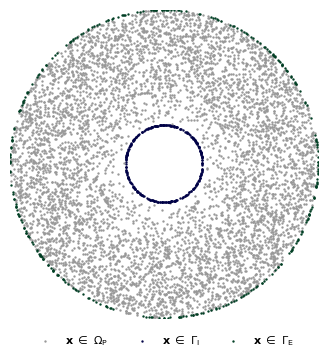

In [ ]:
# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Parameters
nx = 100
n_Omega_P = 6_400        # Number of points inside the annular region
n_Gamma_I = 320#int(nx)          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 320#nx*5         # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4 # Inner radius
r_e = np.pi # Outer radius
k = 2.0  # Wave number
iter = 0  # Iteration counter

# Generate random samples for points inside the annulus
# Randomly sample the radial coordinate between r_i and r_e (uniform in area)
r_samples = r_i + (r_e - r_i) * np.sqrt(np.random.rand(n_Omega_P))  # Transform for uniform distribution in area
theta_samples = 2 * np.pi * np.random.rand(n_Omega_P)  # Uniform angular distribution between 0 and 2*pi

# Convert to Cartesian coordinates for points inside the annulus
x_f = r_samples * np.cos(theta_samples)
y_f = r_samples * np.sin(theta_samples)

# Generate random points on the inner boundary (r = r_i)
theta_inner = 2 * np.pi * np.random.rand(n_Gamma_I)  # Uniform angular distribution
x_inner = r_i * np.cos(theta_inner)
y_inner = r_i * np.sin(theta_inner)
R_inner = np.sqrt(x_inner**2 + y_inner**2) 
Theta_inner = np.arctan2(y_inner, x_inner)
u_scn_inner, u_inner_ = u_exact_calc_for_pinns(R_inner, Theta_inner, r_i, k)
u_inner = torch.from_numpy(u_scn_inner).to(device)

# Generate random points on the outer boundary (r = r_e)
theta_outer = 2 * np.pi * np.random.rand(n_Gamma_E)  # Uniform angular distribution
x_outer = r_e * np.cos(theta_outer)
y_outer = r_e * np.sin(theta_outer)
R_outer = np.sqrt(x_outer**2 + y_outer**2) 
Theta_outer = np.arctan2(y_outer, x_outer)

u_scn_outer, u_outer_ = u_exact_calc_for_pinns(R_outer, Theta_outer, r_e, k)
u_outer_teo = torch.from_numpy(u_scn_outer).to(device)

# Convert to torch tensors
x_f = torch.from_numpy(x_f).float().to(device).requires_grad_(True)
y_f = torch.from_numpy(y_f).float().to(device).requires_grad_(True)
x_inner = torch.from_numpy(x_inner).float().to(device).requires_grad_(True)
y_inner = torch.from_numpy(y_inner).float().to(device).requires_grad_(True)
x_outer = torch.from_numpy(x_outer).float().to(device).requires_grad_(True)
y_outer = torch.from_numpy(y_outer).float().to(device).requires_grad_(True)

# Initialize the model with specified parameters and apply weights
model = MLP(input_size=2, output_size=2, hidden_layers=3, hidden_units=150, activation_function=nn.Tanh()).to(device)
# Initialize the weights
model.apply(init_weights)

# Plot the points
plt.figure(figsize=(4, 4))
plt.scatter(x_f.cpu().detach().numpy(), y_f.cpu().detach().numpy(), c='#989898ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Omega_{\rm P}$")
plt.scatter(x_inner.cpu().detach().numpy(), y_inner.cpu().detach().numpy(), c='#000146ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm I}$")
plt.scatter(x_outer.cpu().detach().numpy(), y_outer.cpu().detach().numpy(), c='#003e23ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm E}$")
plt.xlim([-r_e, r_e])
plt.ylim([-r_e, r_e])
plt.gca().set_aspect('equal', adjustable='box')

# Adjust the legend position and remove the box
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), frameon=False, ncol=3)

# Remove the ticks
plt.axis('off')

# Show the plot
plt.show()


In [16]:
train_lbfgs(model, x_f, y_f, x_inner, y_inner, x_outer, y_outer, k, u_inner, u_outer_teo, num_iter = 10_000)

LBFGS - Loss: 3.1090513598746297
LBFGS - Loss: 1.5336550872735113
LBFGS - Loss: 0.8694194809544752
LBFGS - Loss: 0.5439819340116101
LBFGS - Loss: 0.42977841722434623
LBFGS - Loss: 0.37275582334984514
LBFGS - Loss: 0.33681776129578866
LBFGS - Loss: 0.30503565442090164
LBFGS - Loss: 0.27460841539899206
LBFGS - Loss: 0.24938919846291668
LBFGS - Loss: 0.2251793121917567
LBFGS - Loss: 0.2006569870061266
LBFGS - Loss: 0.1763997514355702
LBFGS - Loss: 0.15130874734136918


KeyboardInterrupt: 

In [17]:
# Número de muestras en x y y
dom_samples = 500
x = np.linspace(-np.pi, np.pi, dom_samples)
y = np.linspace(-np.pi, np.pi, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

def u_exact(x, y, k):
    ikx = -1j * x * k
    exp_ikx =  np.exp(ikx)    
    return exp_ikx

R_exact = np.sqrt(X**2 + Y**2) 
u_amp_exact = np.real(u_exact(X, Y, k))

In [18]:
# Convertir los datos X e Y a tensores de PyTorch y cambiar su forma
X_ten = torch.tensor(X).float().reshape(-1, 1).to(device)
Y_ten = torch.tensor(Y).float().reshape(-1, 1).to(device)

# Concatenar los tensores X e Y en un solo tensor
domain_ten = torch.cat([X_ten,Y_ten], dim = 1) 
U_pred = model(domain_ten)
U_real = U_pred[:, 0].detach().cpu().numpy().reshape(X.shape)
U_imag = U_pred[:, 1].detach().cpu().numpy().reshape(X.shape)

In [19]:
u_amp_exact = np.ma.masked_where(R_exact < r_i, u_amp_exact)
u_amp_exact = np.ma.masked_where(R_exact > r_e, u_amp_exact)
U_real = np.ma.masked_where(R_exact < r_i, U_real)
U_real = np.ma.masked_where(R_exact > r_e, U_real)

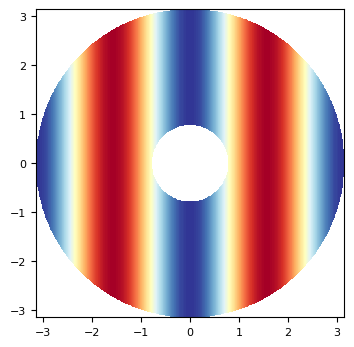

In [20]:
plt.figure(figsize=(4, 4))
plt.contourf(X, Y, u_amp_exact, cmap='RdYlBu', levels=150, vmin=-1, vmax=1)
#plt.axis("off")
plt.gca().set_aspect("equal")
plt.show()

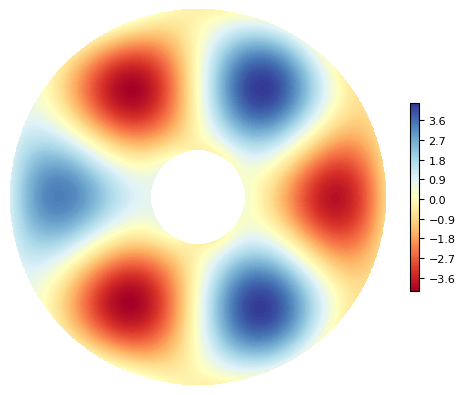

In [21]:
plt.figure(figsize=(5, 5))


plt.contourf(X, Y, U_real, cmap='RdYlBu', levels=150)
plt.colorbar(shrink=0.4)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axis("image")
plt.grid(False)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.tight_layout()